# Imports

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from utils.data import load_breast_cancer_kagglehub, standardize_fit_transform
from utils.internal_metrics import silhouette_score
from PCA.pca_numpy import PCA
from KMeans.kmeans_numpy import KMeans

# Load and standardize dataset

In [2]:
X, y, feature_names = load_breast_cancer_kagglehub()
Xs, scaler = standardize_fit_transform(X)

Loaded CSV: C:\Users\Wind\.cache\kagglehub\datasets\uciml\breast-cancer-wisconsin-data\versions\2\data.csv


# PCA + K-Means evaluation

In [3]:
components_list = [2, 5, 10, 15, 20]
k = 2
seed = 42

recon_errors = []

sil_pp, sil_r = [], []
iters_pp, iters_r = [], []
inertia_pp, inertia_r = [], []

for m in components_list:
    pca = PCA(n_components=m, random_state=seed)
    Z = pca.fit_transform(Xs)

    # --- KMeans++ ---
    km_pp = KMeans(n_clusters=k, init="kmeans++", max_iter=300, tol=1e-4, random_state=seed)
    labels_pp = km_pp.fit_predict(Z)
    sil_pp.append(silhouette_score(Z, labels_pp))
    iters_pp.append(km_pp.n_iter_)
    inertia_pp.append(km_pp.inertia_)

    # --- Random init ---
    km_r = KMeans(n_clusters=k, init="random", max_iter=300, tol=1e-4, random_state=seed)
    labels_r = km_r.fit_predict(Z)
    sil_r.append(silhouette_score(Z, labels_r))
    iters_r.append(km_r.n_iter_)
    inertia_r.append(km_r.inertia_)

    # recon error (same PCA)
    rec_err = pca.reconstruction_error(Xs)
    recon_errors.append(rec_err)

    print(f"m={m:2d} | Recon={rec_err:.6f} | Sil++={sil_pp[-1]:.4f}, it++={iters_pp[-1]:2d} | "
          f"SilR={sil_r[-1]:.4f}, itR={iters_r[-1]:2d}")


m= 2 | Recon=0.367568 | Sil++=0.5085, it++= 7 | SilR=0.5085, itR= 8
m= 5 | Recon=0.152657 | Sil++=0.3932, it++= 9 | SilR=0.3919, itR= 7
m=10 | Recon=0.048431 | Sil++=0.3577, it++= 8 | SilR=0.3565, itR= 7
m=15 | Recon=0.013512 | Sil++=0.3481, it++= 8 | SilR=0.3461, itR= 6
m=20 | Recon=0.004428 | Sil++=0.3459, it++= 8 | SilR=0.3438, itR= 6


# Plots

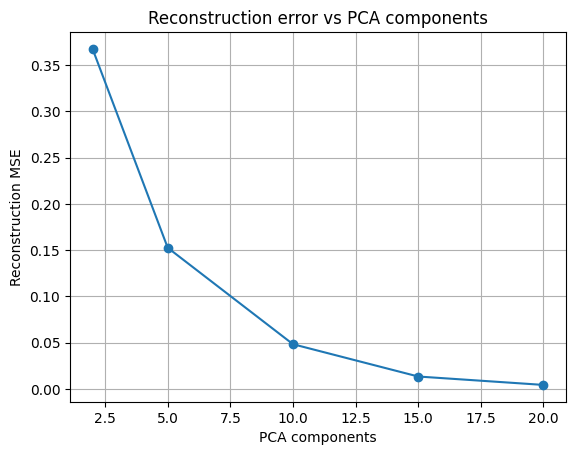

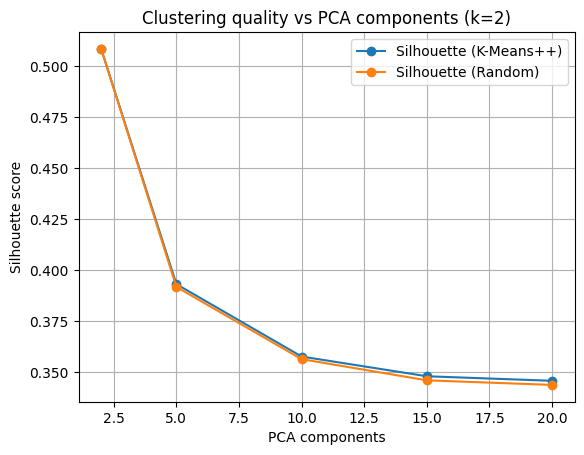

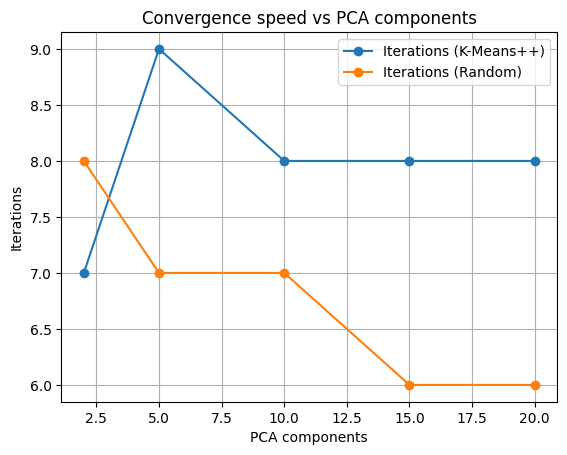

In [4]:
plt.figure()
plt.plot(components_list, recon_errors, marker="o")
plt.xlabel("PCA components")
plt.ylabel("Reconstruction MSE")
plt.title("Reconstruction error vs PCA components")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(components_list, sil_pp, marker="o", label="Silhouette (K-Means++)")
plt.plot(components_list, sil_r, marker="o", label="Silhouette (Random)")
plt.xlabel("PCA components")
plt.ylabel("Silhouette score")
plt.title("Clustering quality vs PCA components (k=2)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(components_list, iters_pp, marker="o", label="Iterations (K-Means++)")
plt.plot(components_list, iters_r, marker="o", label="Iterations (Random)")
plt.xlabel("PCA components")
plt.ylabel("Iterations")
plt.title("Convergence speed vs PCA components")
plt.grid(True)
plt.legend()
plt.show()


# PCA 2D visualization with K-Means clustering
Visualization only – not used for training or evaluation

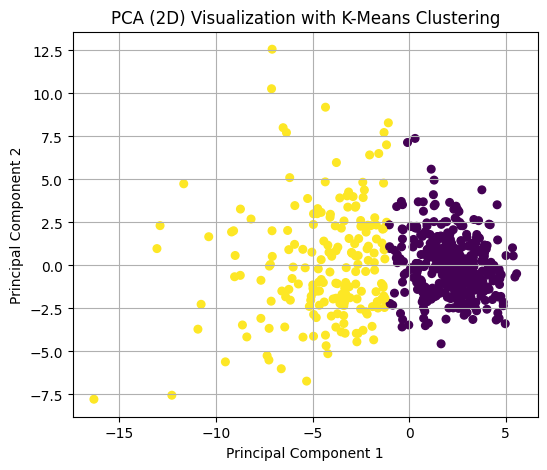

In [5]:
# Reduce data to 2 principal components
pca_vis = PCA(n_components=2, random_state=42)
Z2 = pca_vis.fit_transform(Xs)

# Apply K-Means on PCA space
km_vis = KMeans(n_clusters=2, init="kmeans++", random_state=42)
labels_vis = km_vis.fit_predict(Z2)

# Scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(Z2[:, 0], Z2[:, 1], c=labels_vis, cmap="viridis", s=30)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA (2D) Visualization with K-Means Clustering")
plt.grid(True)
plt.show()

The two PCA scatter plots share identical point locations since they use the same
2D PCA projection. The difference lies only in coloring: one reflects unsupervised
K-Means cluster assignments, while the other shows true diagnosis labels, allowing
qualitative comparison without using labels during training.